## GAMs with Simulated Data

In this example, we show how to check the validity of a GAM (using the gam() function in R), through simulated data. This allows us to try and understand the intricacies of gam() without having to worry about the context of the data. Can we adapt this to our model, to generate a synthetic response/death count given the real predictors?

First, we construct three predictor variables. The goal here is to construct a GAM with different types of predictor terms (e.g., factors, continuous variables, some that will enter linearly/parametrically, some that enter transformed).

1. x1: A continuous predictor that, we will suppose has a nonlinear relationship with the response.
2. x2: A categorical variable that takes values in $\{s, m, t\}$.
3. x3: A categorical variable with two levels.

In [1]:
library(ggplot2)
set.seed(12)

#construct predictors 
n = 100
d <- data.frame(
   x1=rnorm(n, mean = 45, sd = 15),
   x2=sample(c('s','m','t'),size=n,replace=TRUE),
   x3=sample(c(F,T),size=n,replace=TRUE),
 stringsAsFactors=F)
#log(d$x1^2)

Then, we make the response some nonlinear/nonparametric function of x1. In a realworld situation, we wouldn't know this functional relationship and would estimate it. Other terms are modeled parametrically. The response has normal noise.

The model here is a Poisson GAM, with true relationship $$\log(\mu_i) = \beta_1 + log(0.5x_1^2) - x_2 + x_3.$$
Note that 

1. the construction of $\mu$ has the linear predictor exponentiated, because of the nature of the link function. 
2. We use $\mu$ to construct $y$. The assumption for Poisson regression is that $Y_i$ is Poisson with mean $\mu_i$. 
3. as.integer(as.factor(VARIABLE)) converts the labels of VARIABLE to 1, 2, 3,.. so that we can construct the relationship for these factors.

[1]   95.54783 2356.92904 1276.71031  179.05338   15.29710 2275.31469

[1]   66 2358 1240  166   21 2300

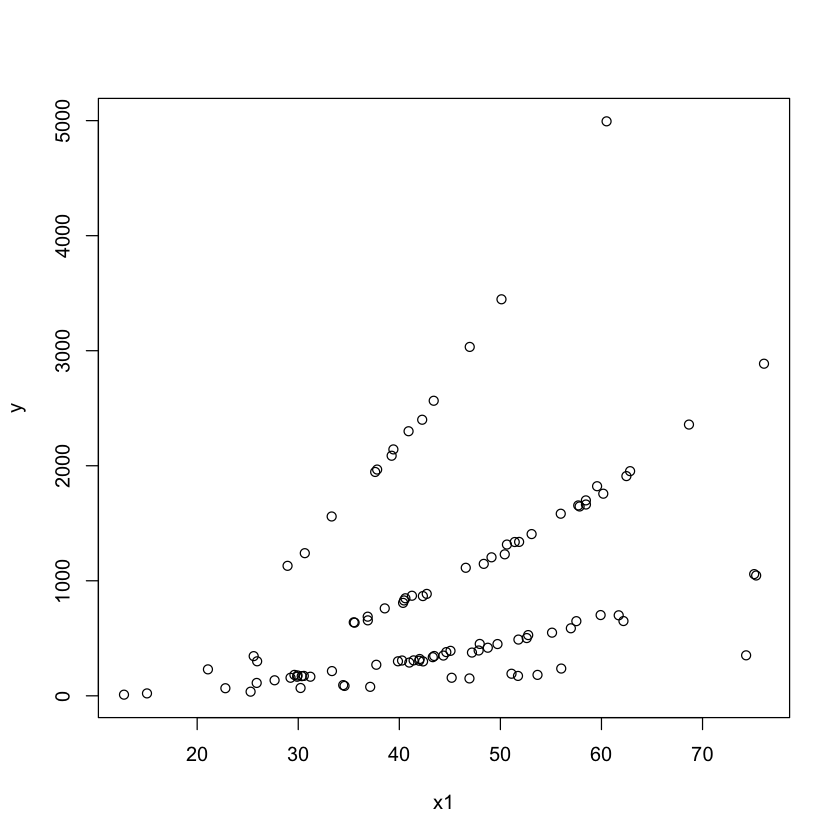

In [2]:
#construct response
d$mu = with(d, exp(log(0.5*x1^2) - as.integer(as.factor(x2)) + as.integer(as.factor(x3))))

d$y = rpois(n, d$mu); #head(d$y)
with(d, plot(x1, y))

head(d$mu) #simulated mean values
head(d$y)  #simulated response values


Let's run a generalized linear model and show why this model doesn't fit all that well. The fit will be distorted by the log relationship with $x_1$. Then we'll fit a GAM.

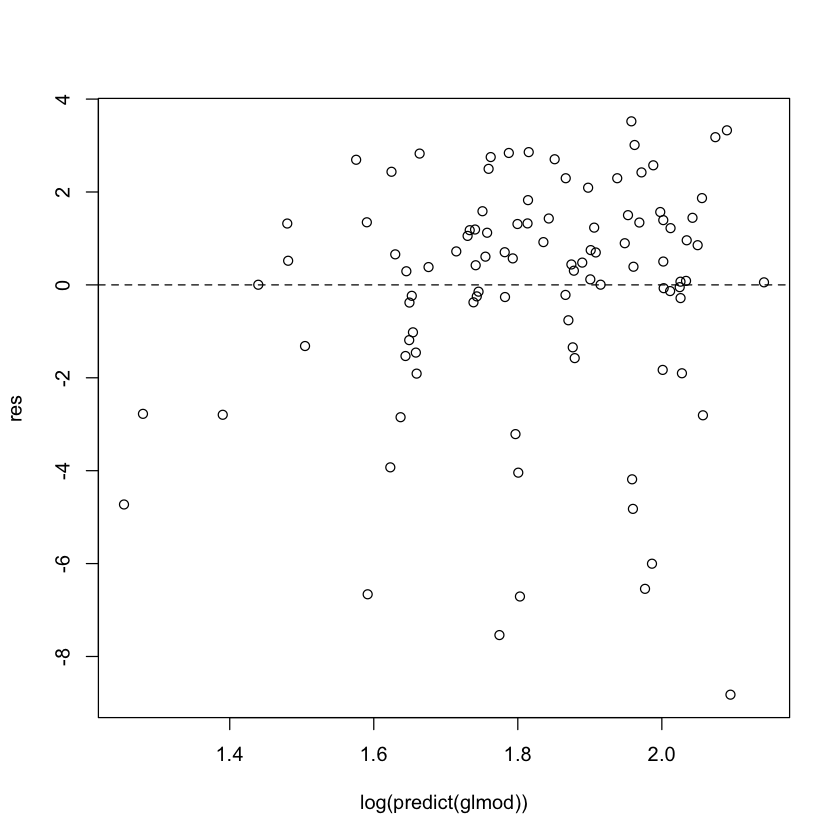

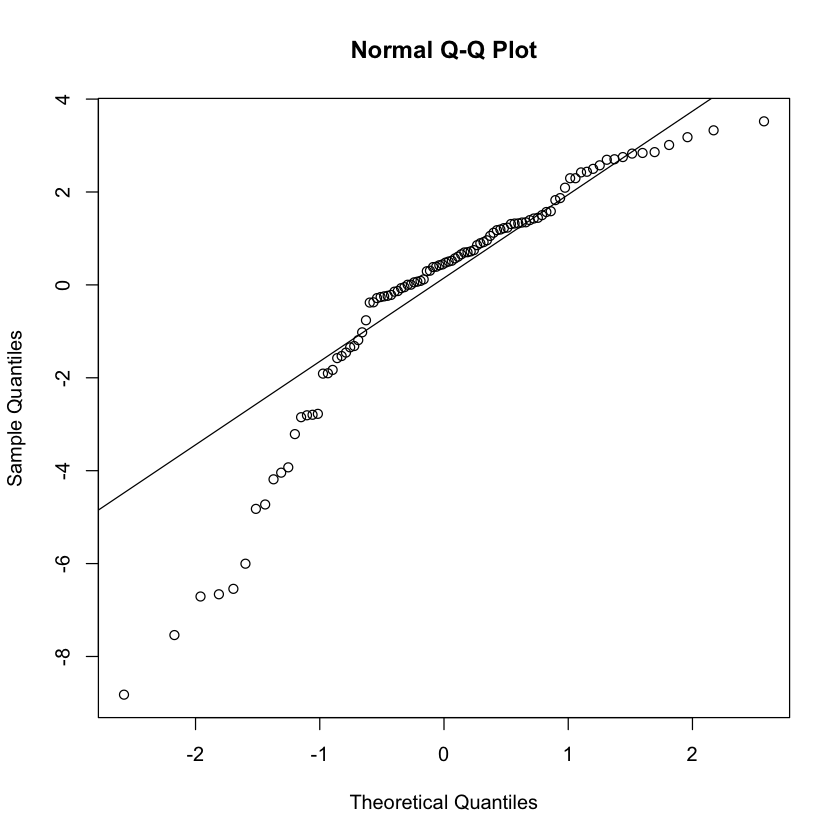

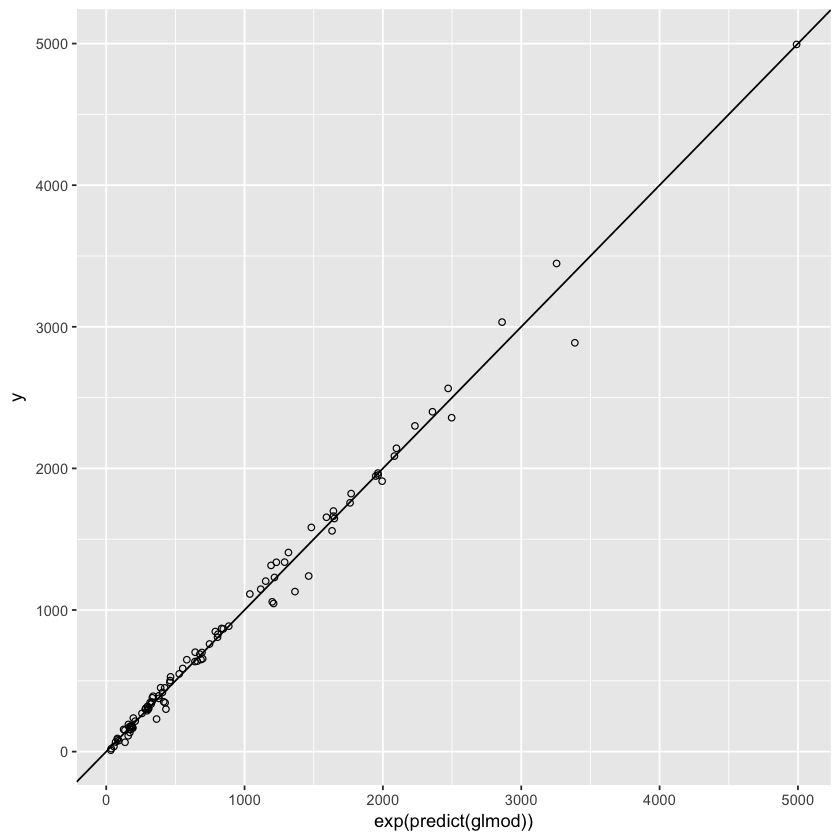

In [3]:
glmod = glm(y ~ x1 + as.integer(as.factor(x2)) + as.integer(as.factor(x3)), d, family = poisson)

res <- residuals(glmod, type="deviance") #compute the deviance residuals

#residual plot
plot(log(predict(glmod)), res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)

#fitted vs actual
ggplot(d,aes(exp(predict(glmod)),y)) + geom_point(shape=1) + geom_abline(slope=1)



Notice above that the residual plots aren't horrible, but there's some skew. And, the QQ plot doesn't look good. We'll also see that the prediction error is higher than using a GAM.

If we fit the model with using the known relationship, we get a better fit. See below. Of course we can't ever do that in practice (without good theory) or through guessing. 

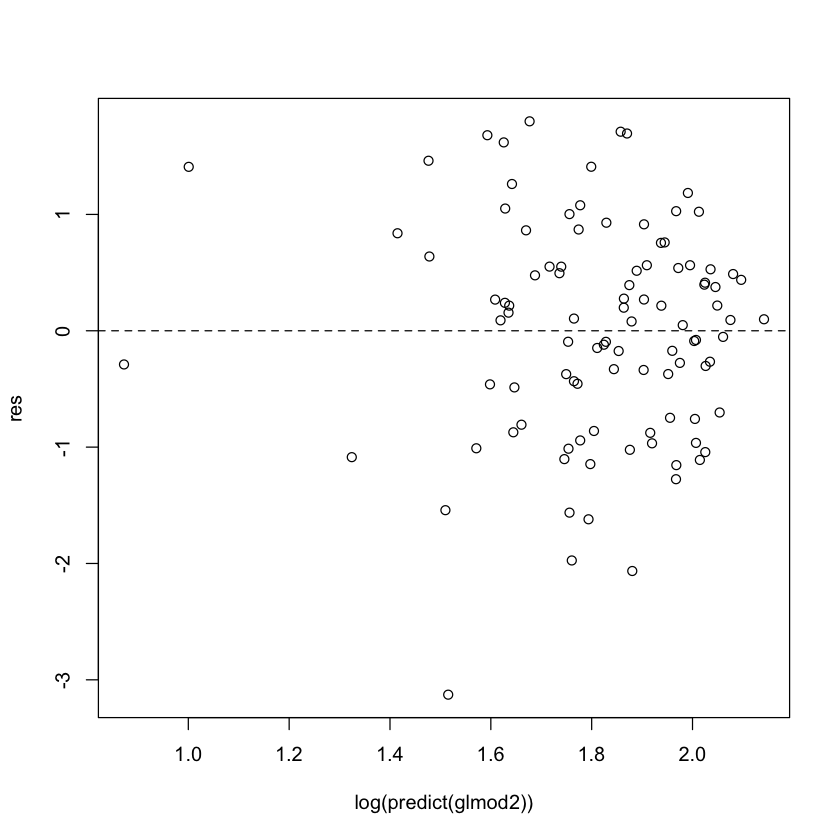

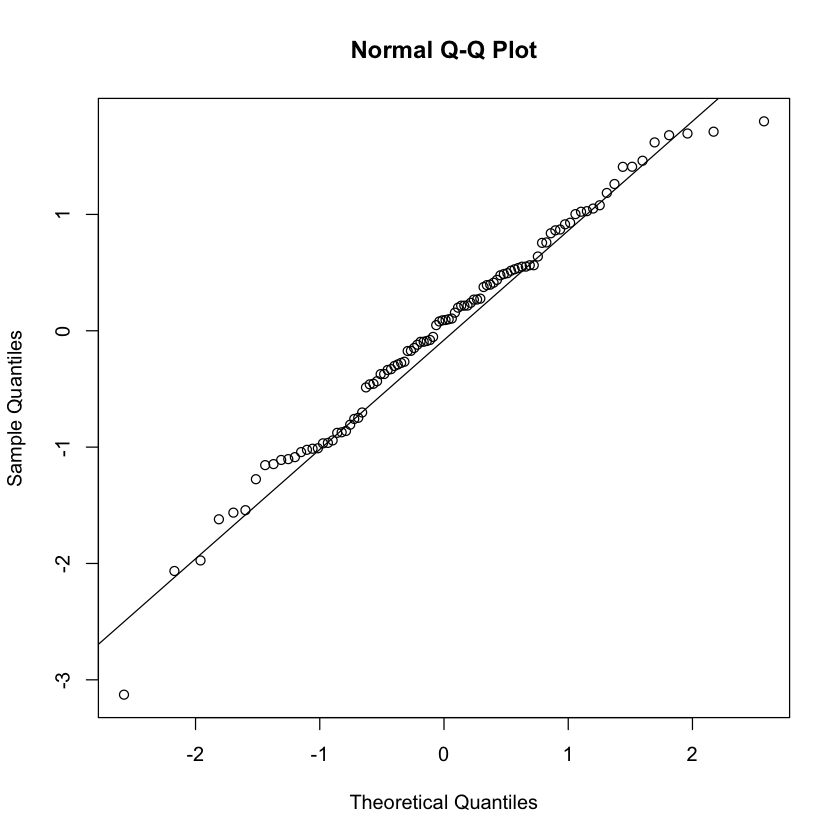

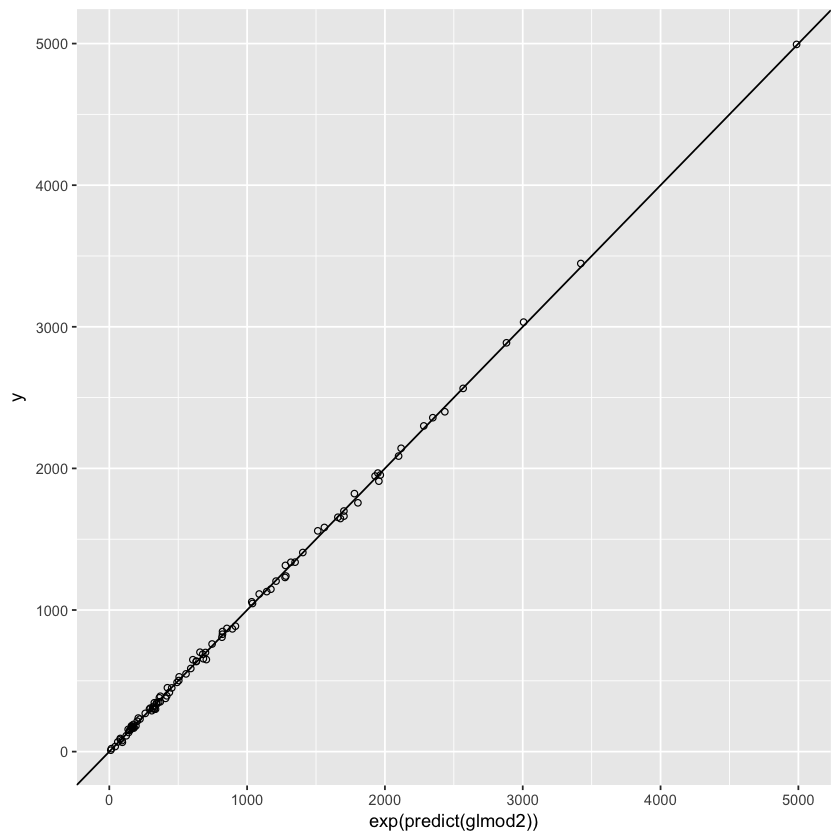

In [4]:
glmod2 = glm(y ~ log(0.5*x1^2) + as.integer(as.factor(x2)) + as.integer(as.factor(x3)), d, family = poisson)
pred_error = sum((exp(predict(glmod2))-d$y)^2); #pred_error

#par(mfrow = c(2,2)); #plot(mod2)
res <- residuals(glmod2, type="deviance") #compute the deviance residuals
#plot(y~log(0.005*x1^2), data=d) 
#predicted = predict(glmod2)
#plot(predicted, d$y)

#residual plot
plot(log(predict(glmod2)), res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)

#fitted vs actual
ggplot(d,aes(exp(predict(glmod2)),y)) + geom_point(shape=1) + geom_abline(slope=1)

So, when we don't know the true relationship, we try to estimate it using GAMs.

Loading required package: nlme
This is mgcv 1.8-16. For overview type 'help("mgcv-package")'.


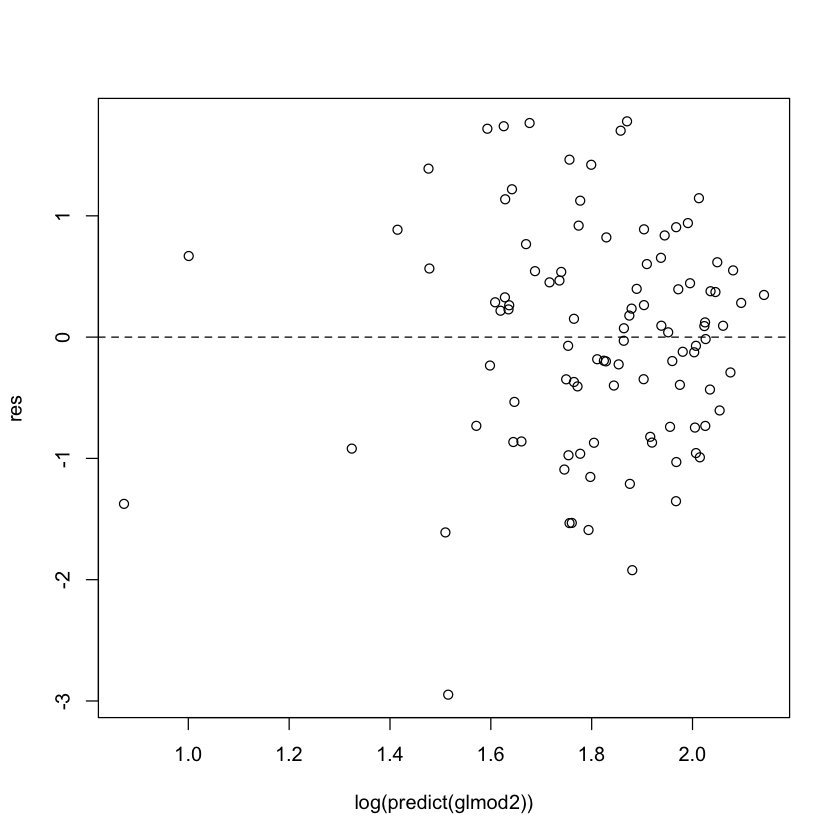

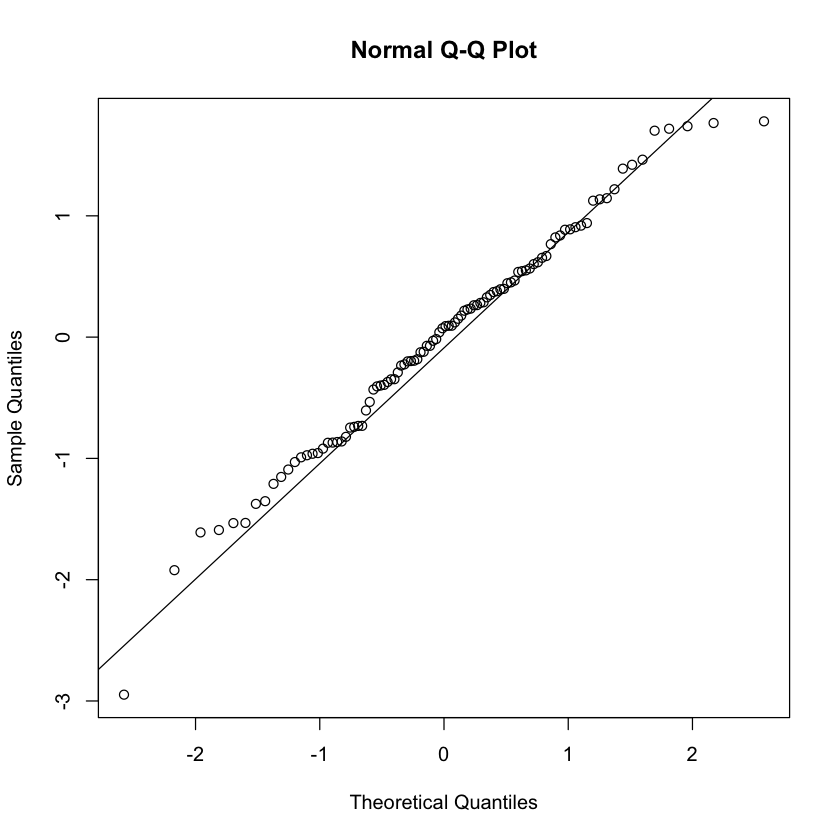

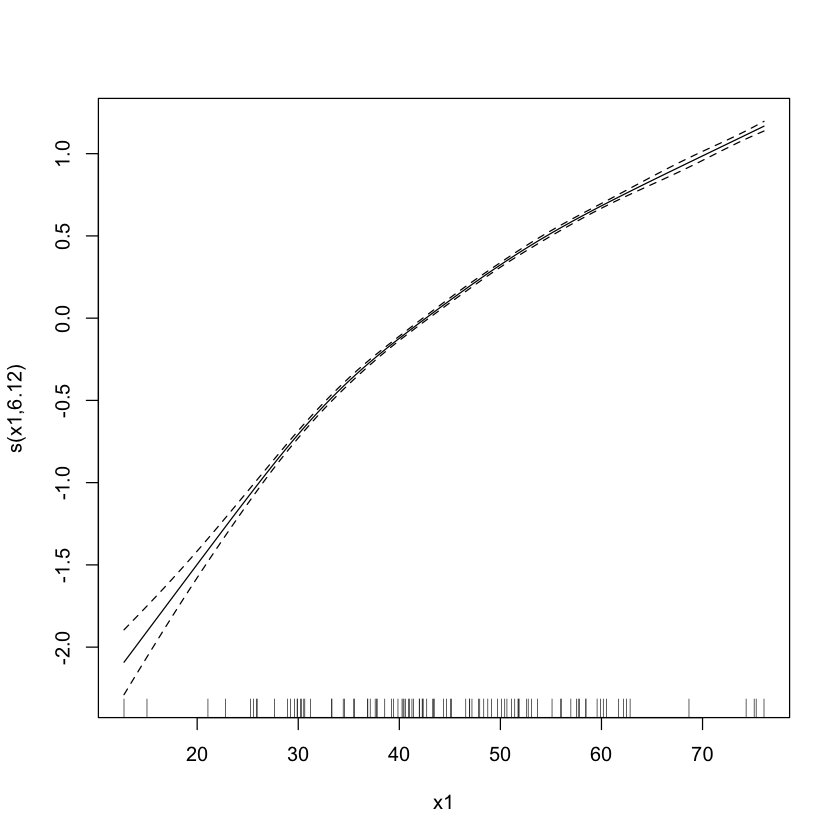

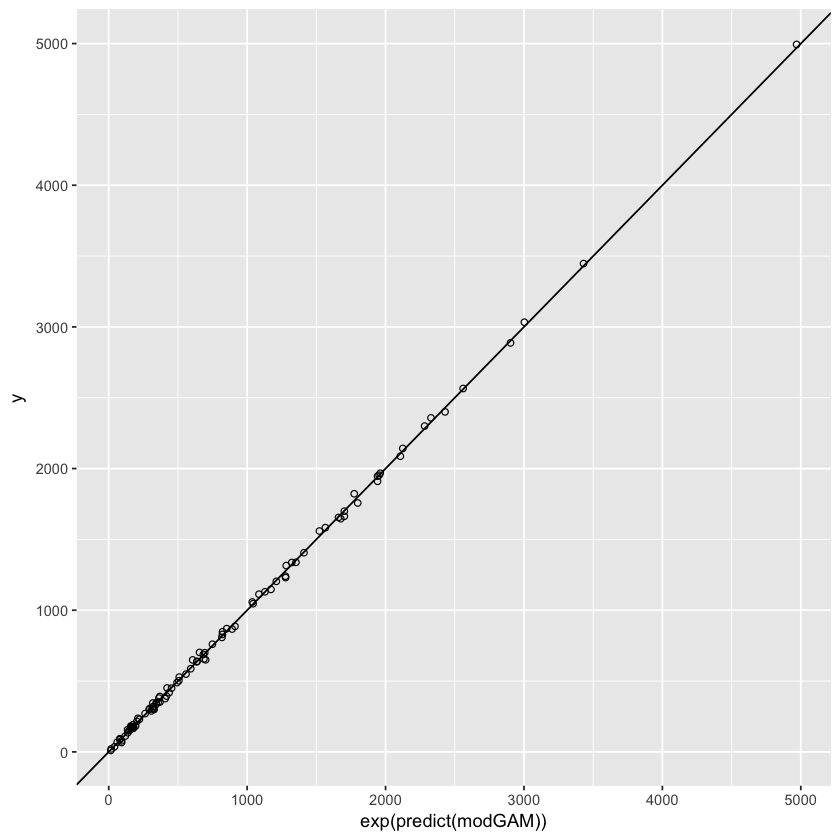

In [5]:
library(mgcv)
modGAM <- gam(y ~ s(x1) + as.integer(as.factor(x2)) + as.integer(as.factor(x3)), data=d, family = poisson)

res <- residuals(modGAM, type="deviance") #compute the deviance residuals

#residual and QQ plot
plot(log(predict(glmod2)), res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)
plot(modGAM) 

#fitted vs actual
ggplot(d,aes(exp(predict(modGAM)),y)) + geom_point(shape=1) + geom_abline(slope=1)



Method: UBRE   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [1.684572e-10,1.684572e-10]
(score -0.007220951 & scale 1).
Hessian positive definite, eigenvalue range [0.0234574,0.0234574].
Model rank =  12 / 12 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

         k'   edf k-index p-value
s(x1) 9.000 6.124   0.855    0.06



Family: poisson 
Link function: log 

Formula:
y ~ s(x1) + as.integer(as.factor(x2)) + as.integer(as.factor(x3))

Parametric coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                6.816974   0.014878   458.2   <2e-16 ***
as.integer(as.factor(x2)) -1.005862   0.005568  -180.6   <2e-16 ***
as.integer(as.factor(x3))  1.000533   0.007337   136.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
        edf Ref.df Chi.sq p-value    
s(x1) 6.124   7.22  19608  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.999   Deviance explained = 99.9%
UBRE = -0.007221  Scale est. = 1         n = 100

[1] 42871.74

[1] 46072.4

[1] 683376.6

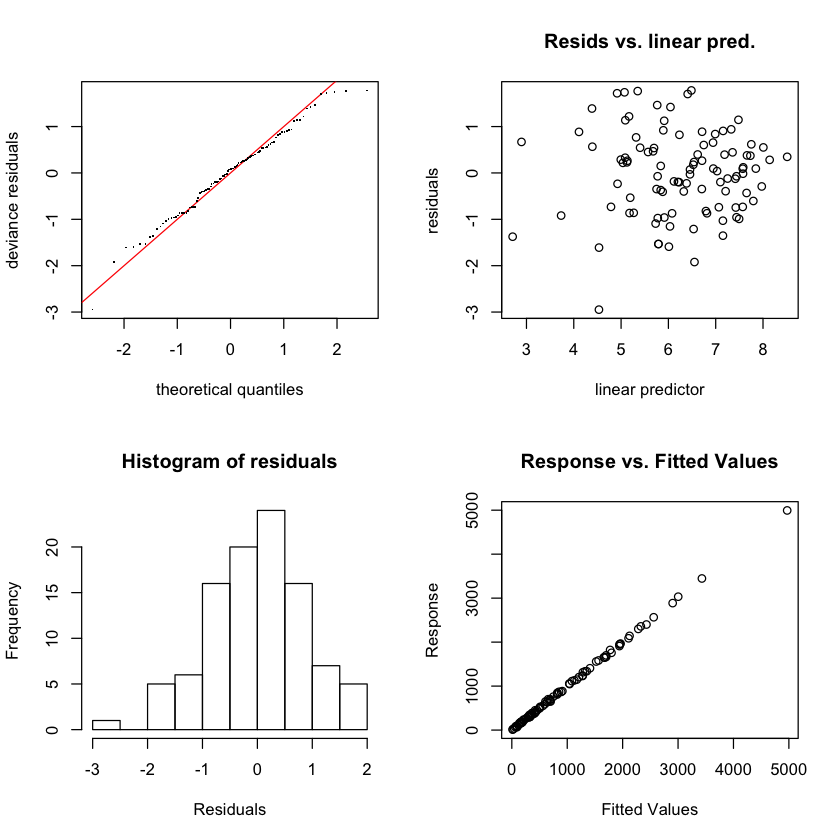

In [6]:
gam.check(modGAM)
summary(modGAM)
pred_errorGAM = sum((exp(predict(modGAM))-d$y)^2); pred_errorGAM
pred_errorGLMKnown = sum((exp(predict(glmod2))-d$y)^2); pred_errorGLMKnown
pred_errorGLM = sum((exp(predict(glmod)) - d$y)^2); pred_errorGLM
